# Imports

In [ ]:
!pip install opencv-python
!pip install open3d
!pip install matplotlib
!pip install torch
!pip install timm

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.3 MB/s eta 0:00:00


In [65]:
import os
import torch
import numpy as np
import cv2 as cv
import open3d as o3d
from matplotlib import pyplot as plt
from google.colab import drive

# Global variables

In [ ]:
drive.mount('/content/drive')

# Define the Google Drive directories of the files
cam_calibration_dir_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Calibration'
stereo_map_save_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Stereo Map/stereo-map.xml'
stereo_images_dir_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Photos'
processed_images_dir_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Depth Maps'

# Open3D Translate Function Multiplier
X = 2000.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
def get_image_pairs(directory_path, left_substr="_LC", right_substr="_RC"):
    '''Retrieve one or more image pairs (in '.jpg' or '.png' format) from the target directory based on their substring keywords (ex. "_LC" for left and "_RC" for right),
       and each image has a file name and image data.
    '''
    image_pairs = []

    # Get a sorted list of all images in the directory
    image_files = sorted(os.listdir(directory_path))

    # Separate the left and right images into two lists
    left_images = [file for file in image_files if left_substr in file]
    right_images = [file for file in image_files if right_substr in file]

    # Create a dictionary of left images, keyed by their base name
    left_image_dict = {file.split(left_substr)[0]: file for file in left_images}

    # Iterate through the right images, and find their corresponding left image
    for right_file in right_images:
        base_name = right_file.split(right_substr)[0]  # Extract base name
        if base_name in left_image_dict:
            left_file = left_image_dict[base_name]  # Get the corresponding left image
            # Read both images using OpenCV
            left_image = cv.imread(os.path.join(directory_path, left_file))
            right_image = cv.imread(os.path.join(directory_path, right_file))

            # Append the image pair (image name, image data) as a tuple
            image_pairs.append([(left_file, left_image), (right_file, right_image)])

    return image_pairs

In [ ]:
def display_images(image_pairs, scale_factor=0.5):
    '''Display the image pairs with scaled-down sizes in Google Colab.'''
    plt.figure(figsize=(10, 10))

    for i, pair in enumerate(image_pairs):
        # Scale down the images
        left_image = cv.resize(pair[0][1], (0, 0), fx=scale_factor, fy=scale_factor)
        right_image = cv.resize(pair[1][1], (0, 0), fx=scale_factor, fy=scale_factor)

        # Display the left image
        plt.subplot(4, 2, 2 * i + 1)
        plt.imshow(cv.cvtColor(left_image, cv.COLOR_BGR2RGB))
        plt.title(f"Left Image: {pair[0][0]}")
        plt.axis('off')

        # Display the right image
        plt.subplot(4, 2, 2 * i + 2)
        plt.imshow(cv.cvtColor(right_image, cv.COLOR_BGR2RGB))
        plt.title(f"Right Image: {pair[1][0]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [61]:
def get_calib_images(dir_path):
    '''Retrieve calibration images from Google Drive (in '.jpg' or '.png' format).
    Args:
        dir_path: The path to the directory containing calibration images.
    Returns:
        images: A dictionary containing left and right images.
    '''
    images = {'left': [], 'right': []}

    # Retrieve all files located inside specific directory
    print(f" >>> Searching directory: \"{dir_path}\"")

    for file_name in os.listdir(dir_path):
        # Check if file is .jpg or .png
        if file_name.endswith(('.jpg', '.png')):
            # Identify whether it's a left or right camera image by the suffix
            if 'LC' in file_name:
                img = cv.imread(os.path.join(dir_path, file_name))
                if img is not None:
                    images['left'].append((file_name, img))  # Store both the filename and image data
            elif 'RC' in file_name:
                img = cv.imread(os.path.join(dir_path, file_name))
                if img is not None:
                    images['right'].append((file_name, img))  # Store both the filename and image data

    print(f" >>> Found {len(images['left'])} left camera images and {len(images['right'])} right camera images for calibration...")
    return images

In [62]:
def show_image_pair(img_left, img_right, img_count, scale_factor=0.5):
    """ Display left and right image pair using matplotlib with optional scaling. """
    left_img_resized = cv.resize(img_left, (0, 0), fx=scale_factor, fy=scale_factor)
    right_img_resized = cv.resize(img_right, (0, 0), fx=scale_factor, fy=scale_factor)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(cv.cvtColor(left_img_resized, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    axes[0].set_title(f'Left Camera Image {img_count + 1}')
    axes[0].axis('off')

    axes[1].imshow(cv.cvtColor(right_img_resized, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    axes[1].set_title(f'Right Camera Image {img_count + 1}')
    axes[1].axis('off')

    plt.show()

In [70]:
def calibrate_stereo_cam(cam_calibration_dir_path, chessboard_size=(10,7), frame_size=(640, 480)):
    '''Generate stereo camera calibration parameters from a set of calibration images for each camera.'''

    # Declare constants & initialize variables
    SIZE_OF_CHESSBOARD_SQUARES_MM = 20  # Size of each Chessboard Square (mm)
    obj_points = []                     # 3D Points in Real World Space
    img_points_left = []                # 2D Points in Image Plane (Left Camera)
    img_points_right = []               # 2D Points in Image Plane (Right Camera)

    # Define Termination Criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Prepare Object Points
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    objp = objp * SIZE_OF_CHESSBOARD_SQUARES_MM

    # Retrieve Images for Calibration
    images = get_calib_images(cam_calibration_dir_path)
    images_left = images['left']
    images_right = images['right']

    img_count = 0
    for img_left_data, img_right_data in zip(images_left, images_right):
        file_name_left, img_left = img_left_data
        file_name_right, img_right = img_right_data

        # Debug: Print the names of the images being processed
        print(f"Processing image pair: {file_name_left} and {file_name_right}")

        # For each image pair, display them
        show_image_pair(img_left, img_right, img_count)

        # Convert to grayscale
        grayL = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
        grayR = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)

        # Find the Chessboard Corners
        retL, cornersL = cv.findChessboardCorners(grayL, chessboard_size, None)
        retR, cornersR = cv.findChessboardCorners(grayR, chessboard_size, None)

        if retL and retR:
            obj_points.append(objp)

            cornersL = cv.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), criteria)
            img_points_left.append(cornersL)

            cornersR = cv.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), criteria)
            img_points_right.append(cornersR)

        else:
            print(f"   * ERROR: Unable to find corners for Image {img_count + 1}")
        img_count += 1  # Increment image count

    if len(img_points_left) > 0 and len(img_points_right) > 0:
        # Stereo Calibration
        print(f"Performing stereo camera calibration...")
        _, camera_matrix_left, dist_coeffs_left, _, _ = cv.calibrateCamera(obj_points, img_points_left, frame_size, None, None)
        _, camera_matrix_right, dist_coeffs_right, _, _ = cv.calibrateCamera(obj_points, img_points_right, frame_size, None, None)

        # Stereo Rectification and Map Calculation
        print(f"Calculating stereo maps...")
        stereo_map_left, stereo_map_right = cv.initUndistortRectifyMap(camera_matrix_left, dist_coeffs_left, None, camera_matrix_left, frame_size, 5)
        stereo_map_right, stereo_map_left = cv.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_right, None, camera_matrix_right, frame_size, 5)

        # Generate stereo-map.xml file
        stereo_map_save_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Stereo Map/stereo-map.xml'
        fs = cv.FileStorage(stereo_map_save_path, cv.FILE_STORAGE_WRITE)

        # Save the calibration parameters and stereo maps
        fs.write("K1", camera_matrix_left)
        fs.write("D1", dist_coeffs_left)
        fs.write("K2", camera_matrix_right)
        fs.write("D2", dist_coeffs_right)
        fs.write("stereoMapL_x", stereo_map_left[0])   # Left camera stereo map
        fs.write("stereoMapL_y", stereo_map_left[1])   # Left camera stereo map
        fs.write("stereoMapR_x", stereo_map_right[0])  # Right camera stereo map
        fs.write("stereoMapR_y", stereo_map_right[1])  # Right camera stereo map
        fs.release()

        print(f"Camera parameters and stereo maps generated and saved to {stereo_map_save_path}")

    else:
        print("Calibration failed: Not enough valid chessboard corners found.")

In [ ]:
def create_pcd(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

# Program


RETRIEVING STEREO IMAGES FROM: "/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Photos"
 >>> Found 4 image pairs...


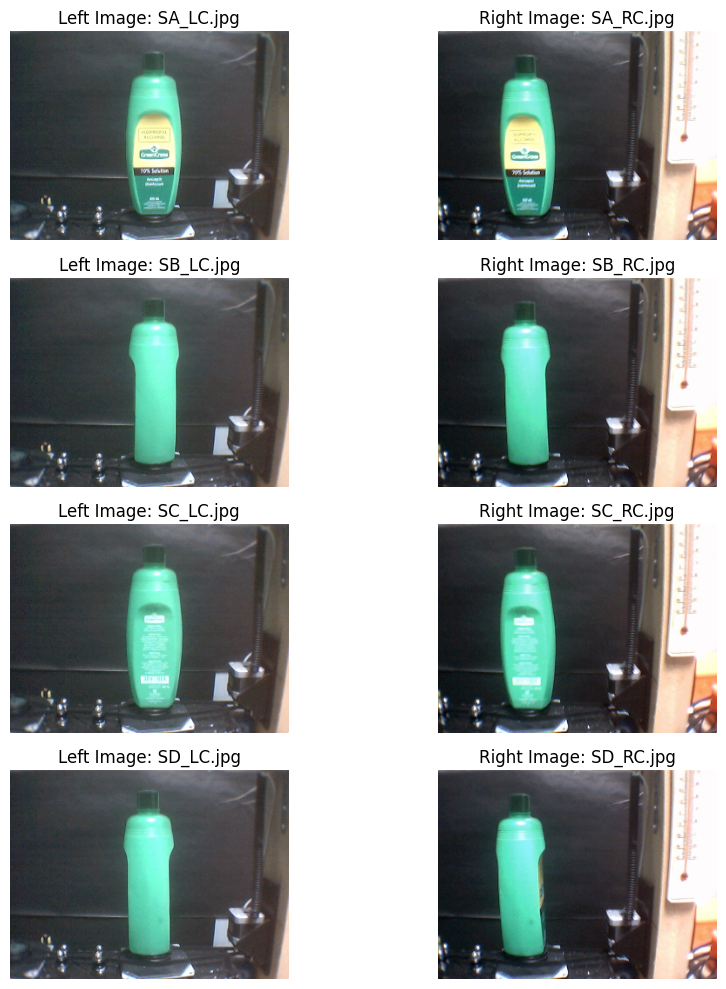

In [ ]:
# ----- 1. RETRIEVE STEREO IMAGES FROM TARGET DIRECTORY INTO IMAGE PAIR DATA STRUCTURE ----- #

print(f"\nRETRIEVING STEREO IMAGES FROM: \"{stereo_images_dir_path}\"")

image_pairs_raw = get_image_pairs(stereo_images_dir_path)

# DEBUG: Display number of image pairs found
print(f" >>> Found {len(image_pairs_raw)} image pairs...")

# Display the images
display_images(image_pairs_raw)

# DEBUG: Display each image filename & image data
# for image_pair in image_pairs_raw:
#     cv.imshow(image_pair[1][0], image_pair[1][1])
#     cv.waitKey(0)
#     cv.imshow(image_pair[0][0], image_pair[0][1])
#     cv.waitKey(0)


RETRIEVING CALIBRATION IMAGES FROM: "/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Calibration"
 >>> Searching directory: "/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Calibration"
 >>> Found 10 left camera images and 10 right camera images for calibration...
Processing image pair: Calibration_A_LC.jpg and Calibration_A_RC.jpg


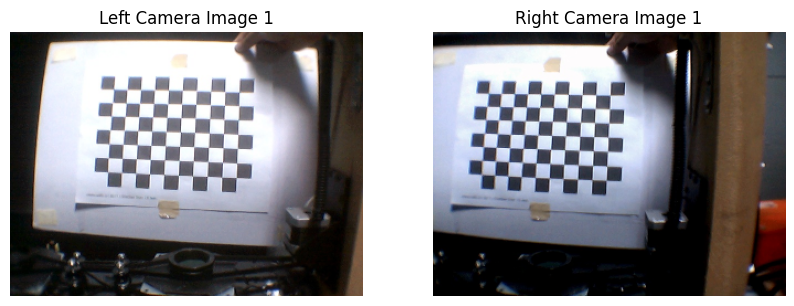

Processing image pair: Calibration_B_LC.jpg and Calibration_B_RC.jpg


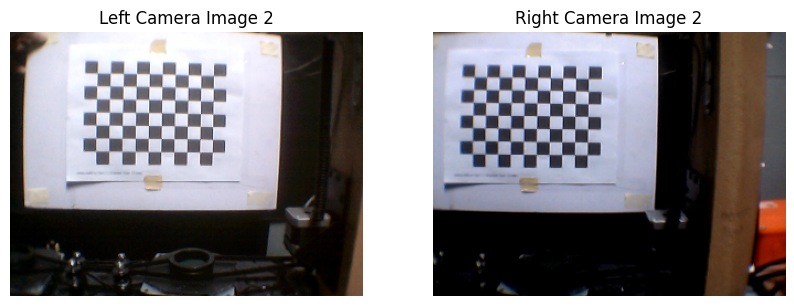

Processing image pair: Calibration_C_LC.jpg and Calibration_C_RC.jpg


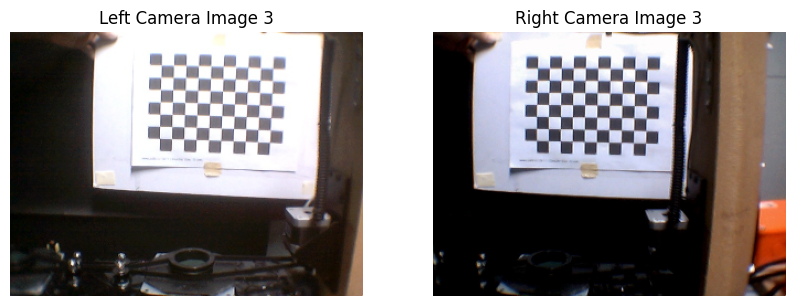

Processing image pair: Calibration_D_LC.jpg and Calibration_D_RC.jpg


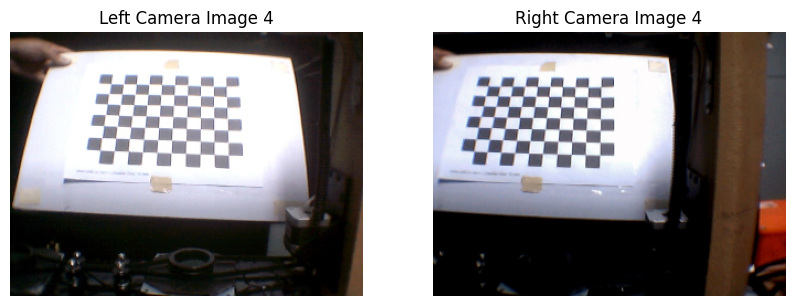

Processing image pair: Calibration_E_LC.jpg and Calibration_E_RC.jpg


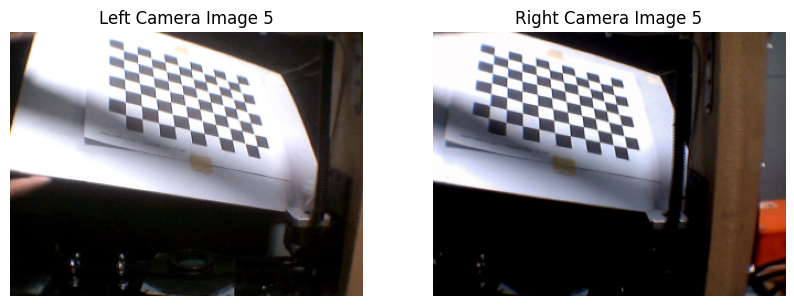

   * ERROR: Unable to find corners for Image 5
Processing image pair: Calibration_F_LC.jpg and Calibration_F_RC.jpg


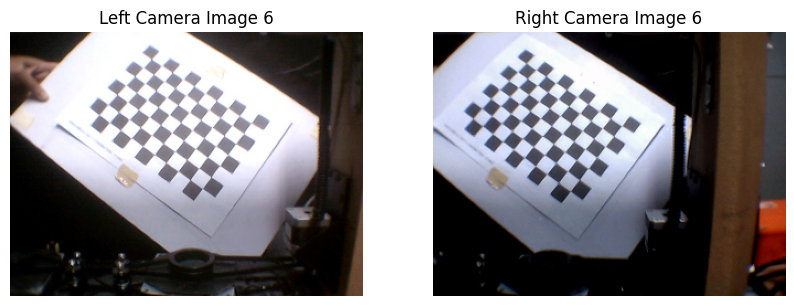

Processing image pair: Calibration_G_LC.jpg and Calibration_G_RC.jpg


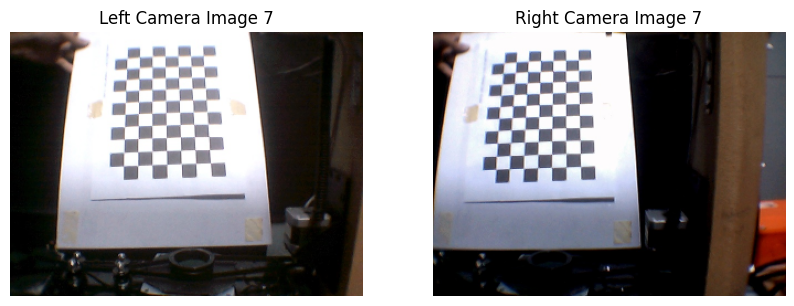

Processing image pair: Calibration_H_LC.jpg and Calibration_H_RC.jpg


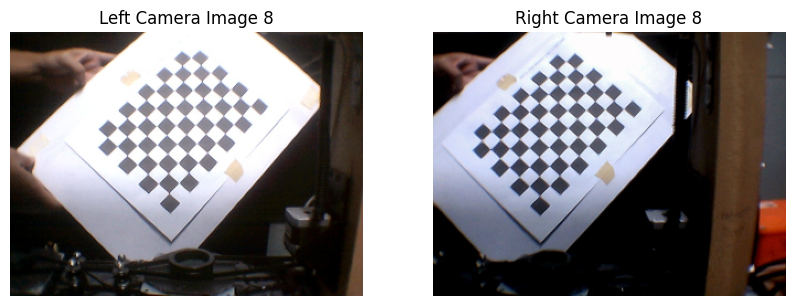

Processing image pair: Calibration_I_LC.jpg and Calibration_I_RC.jpg


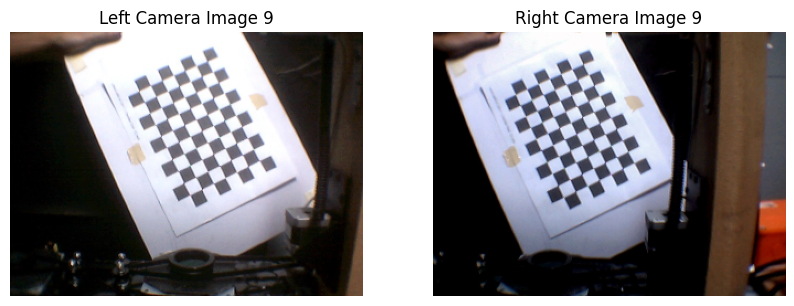

Processing image pair: Calibration_J_LC.jpg and Calibration_J_RC.jpg


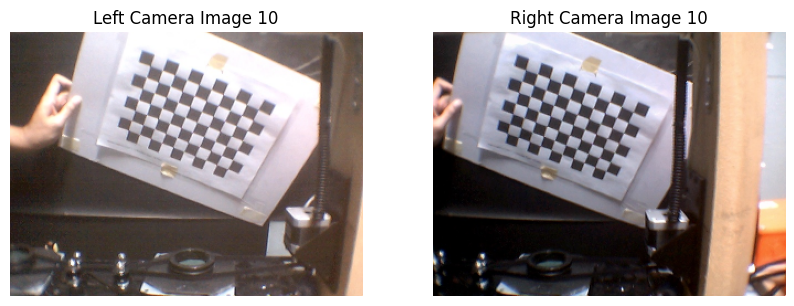

Performing stereo camera calibration...
Calculating stereo maps...
Camera parameters and stereo maps generated and saved to /content/drive/MyDrive/Research Files/Other files/Development/3D Construction/3D Construction of Sir Ralph/Files/Stereo Map/stereo-map.xml


In [71]:
#  ----- 2. PERFORM CAMERA CALIBRATION TO GENERATE CAMERA PARAMETERS ----------------------- #

# DEBUG: Display process & target directory
print(f"\nRETRIEVING CALIBRATION IMAGES FROM: \"{cam_calibration_dir_path}\"")

calibrate_stereo_cam(cam_calibration_dir_path)

In [ ]:
# ----- 3. UNDISTORT STEREO IMAGES USING GENERATED CAMERA PARAMETERS ----------------------- #

# DEBUG: Display process & number of image pairs
print(f"\nUNDISTORTING {len(image_pairs_raw)} IMAGE PAIRS:")

cam_params = cv.FileStorage("stereoMap.xml", cv.FILE_STORAGE_READ)

# DEBUG: Confirm whether camera parameters exist
if cam_params.isOpened():
    print(" >>> Using Camera Parameters with filename: \"stereoMap.xml\"")
else:
    print(" >>> No Camera Parameters found! Perform Camera Calibration first.")
    exit()

# Get parameters from each node
stereoMapL_x = cam_params.getNode("stereoMapL_x").mat()
stereoMapL_y = cam_params.getNode("stereoMapL_y").mat()
stereoMapR_x = cam_params.getNode("stereoMapR_x").mat()
stereoMapR_y = cam_params.getNode("stereoMapR_y").mat()

matrixQ = cam_params.getNode("q").mat()

image_pairs_undistorted = []
# Remap raw stereo images based on camera parameters
for imp in image_pairs_raw:
    undistortedL = cv.remap(imp[1][1], stereoMapL_x, stereoMapL_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)
    undistortedR = cv.remap(imp[0][1], stereoMapR_x, stereoMapR_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

    # Save undistorted image pairs to new variable
    imp_undistorted = [[imp[0][0], undistortedR], [imp[1][0], undistortedL]]
    image_pairs_undistorted.append(imp_undistorted)

# DEBUG: Display number of undistorted image pairs
print(f"PERFORMED UNDISTORTION ON {len(image_pairs_undistorted)} IMAGE PAIRS")

# DEBUG: Display each undistorted image filename & image data
# for image_pair in image_pairs_undistorted:
#     cv.imshow(image_pair[1][0], image_pair[1][1])
#     cv.waitKey(0)
#     cv.imshow(image_pair[0][0], image_pair[0][1])
#     cv.waitKey(0)

In [ ]:
# ----- 4. PERFORM IMAGE SEGMENTATION TO GENERATE OBJECT MASK ------------------------------ #

# DEBUG: Display process & number of image pairs
print(f"\nCREATING OBJECT MASKS FOR {len(image_pairs_undistorted)} IMAGE PAIRS:")

image_masks = []

for im in image_pairs_undistorted:
    # Optional: Switch between im[0][1] and im[1][1] accordingly (which image will the mask be based on)
    img_raw = im[0][1]

    # DEBUG: Show raw image (no segmentation performed)
    # cv.imshow("RAW", img_raw)
    # cv.waitKey(0)

    # Optional: Resize/Crop Image especially if large resolution, reduces processing time
    # img_raw = img_raw[0:640, 0:480]
    # img_raw = cv.resize(img_raw, None, fx=1.0, fx=1.0)

    # Convert Images to Grayscale, and perform thresholding for each image
    img_gray = cv.cvtColor(img_raw, cv.COLOR_BGR2GRAY)

    # Optional: Adjust Minimum and Maximum Threshold based on Contour results
    min_thres = 105
    max_thres = 200

    # Generate Threshold for finding image Contours
    _, th2 = cv.threshold(img_gray, min_thres, max_thres, cv.THRESH_BINARY)

    # Find Image Contours
    contours, hierarchy = cv.findContours(th2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    new_contours = []

    # Optional: Adjust Contour Size based on results
    contour_size = 700

    # Retrieve only Contours with a target minimum number of points (Contour Size)
    for i in range(len(contours)):
        if len(contours[i]) > contour_size:
            new_contours.append(contours[i])

    # DEBUG: Display remaining contours
    # cv.drawContours(img_raw, new_contours, -1, (0, 255, 0), thickness=2)
    # cv.imshow(im[1][0] + "Contour Result", img_raw)
    # cv.waitKey(0)

    # Create Mask from each image
    img_mask = np.zeros((img_raw.shape[0], img_raw.shape[1]), dtype="uint8")
    obj_mask = cv.drawContours(img_mask, new_contours, -1, 255, cv.FILLED)
    image_masks.append(obj_mask)

    # DEBUG: Display Mask Process Result
    # cv.imshow(im[1][0] + "Mask Result", obj_mask)
    # cv.waitKey(0)

# DEBUG: Display process & number of image masks
print(f" >>> Created {len(image_masks)} Object Masks...")

In [ ]:
# ----- 5. GENERATE DEPTH MAPS FROM STEREO IMAGES & APPLY OBJECT MASK ---------------------- #

# DEBUG: Display process & number of image pairs
print(f"\nCREATING DEPTH MAPS & POINT CLOUDS FOR {len(image_pairs_undistorted)} IMAGE PAIRS:")

# Select which MiDaS model to download (MiDas_small < DPT_Hybrid < DPT_Large)
# midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")     # Best Results for Alcohol Bottle Test Object
# midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Input Transformations
transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transforms.small_transform

output_points = None
output_colors = None

for im, mask in zip(image_pairs_undistorted, image_masks):

    # Convert image to RGB format
    img_color = cv.cvtColor(im[0][1], cv.COLOR_BGR2RGB)
    img_batch = transform(img_color).to("cpu")

    # Generate Depth Map
    with torch.no_grad():
        prediction = midas(img_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_color.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    img_depth = cv.normalize(depth_map, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    # DEBUG: Display MiDaS Depth Map Results
    # cv.imshow("midas prediction", img_depth)
    # cv.waitKey(0)

In [ ]:
# ----- 6. GENERATE POINT CLOUDS FROM THE DEPTH MAPS --------------------------------------- #

    # Reproject image to 3D using Camera Parameters (Q Matrix)
    points_3D = cv.reprojectImageTo3D(img_depth, matrixQ, handleMissingValues=False)

    # Apply Mask to image before generating the Point Cloud
    mask_map = mask > 0.4
    output_points = points_3D[mask_map]
    output_colors = img_color[mask_map]

    # Convert Depth Map to 8-bit Unsigned Integer Datatype & Add Color Data
    img_depth = (img_depth*255).astype(np.uint8)
    img_depth = cv.applyColorMap(img_depth , cv.COLORMAP_MAGMA)

    # Save Point Cloud with specified filename
    output_file = im[0][0].replace(im[0][0][17:], ".ply")

    # DEBUG: Display Color Map, Depth Map, and Object Mask
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(output_file)

    fig.add_subplot(1, 3, 1)
    plt.imshow(im[0][1])
    plt.axis("off")
    plt.title("Color")

    fig.add_subplot(1, 3, 2)
    plt.imshow(img_depth)
    plt.axis("off")
    plt.title("Depth")

    fig.add_subplot(1, 3, 3)
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Mask")
    plt.show()

    # Generate Point Cloud
    create_pcd(output_points, output_colors, output_file)

    # DEBUG: Display newly generated Point Clouds
    # pcd = o3d.io.read_point_cloud(output_file)
    # o3d.visualization.draw_geometries([pcd])

# DEBUG: Display number of depth maps & point clouds generated
print(f" >>> Created {len(image_pairs_undistorted)} Depth Maps and {len(image_pairs_undistorted)} Point Clouds...")

In [ ]:
# ----- 7a. REARRANGE POINT CLOUDS TO FORM 3D OBJECT --------------------------------------- #

# Import Point Clouds
pcd_front = o3d.io.read_point_cloud("20240521_image2_5.ply")
pcd_left  = o3d.io.read_point_cloud("20240521_image2_6.ply")
pcd_back  = o3d.io.read_point_cloud("20240521_image2_7.ply")
pcd_right = o3d.io.read_point_cloud("20240521_image2_8.ply")

# ------------------- FRONT -------------------- #
# Remove Outlier Points
cl, ind = pcd_front.remove_statistical_outlier(nb_neighbors=300, std_ratio=0.5)
pcd_front = pcd_front.select_by_index(ind)
cl, ind = pcd_front.remove_radius_outlier(nb_points=10, radius=300)
pcd_front = pcd_front.select_by_index(ind)

# Transform Point Cloud (Translate, Rotate, Scale)
pcd_front.translate((0, 0, 0))
pcd_front.rotate(
    pcd_front.get_rotation_matrix_from_xyz((
        0     - (np.pi * 16/128),    # X Rotation
        np.pi + (np.pi *  3/128),    # Y Rotation
        np.pi + (np.pi *  2/128)     # Z Rotation
    )),
    center=pcd_front.get_center()
)
pcd_front.scale(1.0, center=pcd_front.get_center())

# DEBUG: Get Bounding Box
# box = pcd_front.get_axis_aligned_bounding_box()
# box.color = (1, 0, 0)

# DEBUG: Display Results
# o3d.visualization.draw_geometries([pcd_front, box])

# ------------------- BACK -------------------- #
# Remove Outlier Points
cl, ind = pcd_back.remove_statistical_outlier(nb_neighbors=300, std_ratio=0.5)
pcd_back = pcd_back.select_by_index(ind)
cl, ind = pcd_back.remove_radius_outlier(nb_points=10, radius=300)
pcd_back = pcd_back.select_by_index(ind)

# Transform Point Cloud (Translate, Rotate, Scale)
pcd_back.translate((-0.4 * X, -0.5 * X, -5.2 * X))
pcd_back.rotate(
    pcd_back.get_rotation_matrix_from_xyz((
        0     + (np.pi * 1/128),    # X Rotation
        0     + (np.pi * 3/128),    # Y Rotation
        np.pi + (np.pi * 3/128)     # Z Rotation
    )),
    center=pcd_back.get_center()
)
pcd_back.scale(1.0, center=pcd_back.get_center())

# Warp Point Cloud (to reduce curving)
pcd_back.transform([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, -0.05, 1, 0],
                    [0, 0, 0, 1]])

# DEBUG: Display Results
# o3d.visualization.draw_geometries([pcd_back, box])

# ------------------- LEFT -------------------- #
# Remove Outlier Points
cl, ind = pcd_left.remove_statistical_outlier(nb_neighbors=300, std_ratio=0.25)
pcd_left = pcd_left.select_by_index(ind)
cl, ind = pcd_left.remove_radius_outlier(nb_points=10, radius=250)
pcd_left = pcd_left.select_by_index(ind)

# Transform Point Cloud (Translate, Rotate, Scale)
pcd_left.translate((1.5 * X, -0.5 * X, -6 * X))
pcd_left.rotate(
    pcd_left.get_rotation_matrix_from_xyz((
        0     - (np.pi * 106/128),    # X Rotation
        np.pi + (np.pi *  56/128),    # Y Rotation
        np.pi - (np.pi * 102/128)     # Z Rotation
    )),
    center=pcd_left.get_center()
)
pcd_left.scale(0.9, center=pcd_left.get_center())

# DEBUG: Display Results
# o3d.visualization.draw_geometries([pcd_left, box])

# ------------------- RIGHT -------------------- #
# Remove Outlier Points
cl, ind = pcd_right.remove_statistical_outlier(nb_neighbors=300, std_ratio=0.25)
pcd_right = pcd_right.select_by_index(ind)
cl, ind = pcd_right.remove_radius_outlier(nb_points=7, radius=240)
pcd_right = pcd_right.select_by_index(ind)

# Transform Point Cloud (Translate, Rotate, Scale)
pcd_right.translate((-3.3 * X, -1 * X, -14 * X))
pcd_right.rotate(
    pcd_right.get_rotation_matrix_from_xyz((
        0     - (np.pi *  6/128),    # X Rotation
        np.pi - (np.pi * 54/128),    # Y Rotation
        np.pi + (np.pi *  4/128)     # Z Rotation
    )),
    center=pcd_right.get_center()
)
pcd_right.scale(0.68, center=pcd_right.get_center())

# Warp Point Cloud (to reduce curving)
pcd_right.transform([[1, 0.1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0.1, 1, 0],
                     [0, 0, 0, 1]])

# DEBUG: Display Results
# o3d.visualization.draw_geometries([pcd_right, box])

In [ ]:
# ----- 7b. MERGE POINT CLOUDS INTO A SINGLE POINT CLOUD ----------------------------------- #

# DEBUG: Display process & number of image pairs
print(f"\nMERGING 4 POINT CLOUDS: ")

# Merge all point clouds
merged_pcd = pcd_front + pcd_left + pcd_back + pcd_right

# DEBUG: Display Merged Point Cloud
# o3d.visualization.draw_geometries([merged_pcd])

# Remove Remaining Outlier Points
cl, ind = merged_pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=1.75)
merged_pcd = merged_pcd.select_by_index(ind)
cl, ind = merged_pcd.remove_radius_outlier(nb_points=10, radius=300)
merged_pcd = merged_pcd.select_by_index(ind)

# DEBUG: Display Cleaned Point Cloud
# o3d.visualization.draw_geometries([merged_pcd])

# Define merged Point Cloud filename
pcd_filename = "merged_pcd.ply"

# DEBUG: Display filename
print(f" >>> Saved Point Cloud with filename: \"{pcd_filename}\" ...")

# Save Point Cloud to Directory
o3d.io.write_point_cloud(pcd_filename, merged_pcd)

In [ ]:
# ----- 8. CONVERT POINT CLOUD INTO 3D MESH ------------------------------------------------ #

# DEBUG: Display process
print(f"\nGENERATING 3D MESH: ")

# Perform Downsampling to reduce time in generating mesh
down_pcd = merged_pcd.voxel_down_sample(voxel_size=1000)

# DEBUG: Display downsampled Point Cloud
# o3d.visualization.draw_geometries([down_pcd])

# Estimate Point Cloud Normals to determine mesh face orientations
down_pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))
down_pcd.estimate_normals()

# DEBUG: Display Point Cloud Normals
# o3d.visualization.draw_geometries([down_pcd], point_show_normal=True)

# ---------------------------------------------------------------- #
# MESH GENERATION METHOD 1: CREATE MESH FROM CONVEX HULL
# Result: Creates a fully-formed 3D Mesh, however the colors from the point clouds was not retained
hull_mesh, _ = down_pcd.compute_convex_hull()
hull_mesh.compute_vertex_normals()

# DEBUG: Display generated Mesh
o3d.visualization.draw_geometries([hull_mesh], mesh_show_back_face=True)

# DEBUG: Display method & filename
print(f" >>> Generated 3D Mesh using Convex Hull Method...")
print(f" >>> Saved 3D Mesh with filename: \"mesh_hull.ply\" ...")

# Save Mesh file to directory
o3d.io.write_triangle_mesh("mesh_hull.ply", hull_mesh)

# ---------------------------------------------------------------- #


# ---------------------------------------------------------------- #
# MESH GENERATION METHOD 2: CREATE MESH FROM BALL PIVOTING ALGORITHM
# Result: Creates a 3D Mesh with the colors retained, however there are holes in the geometry that must be filled
radii = 2.0 * np.mean(down_pcd.compute_nearest_neighbor_distance())
bp_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(down_pcd, o3d.utility.DoubleVector([radii, radii * 10]))

# DEBUG: Display generated Mesh
o3d.visualization.draw_geometries([bp_mesh], mesh_show_back_face=True)

# DEBUG: Display method & filename
print(f" >>> Generated 3D Mesh using Ball Pivoting Algorithm...")
print(f" >>> Saved 3D Mesh with filename: \"mesh_bp.ply\" ...")

# Save Mesh file to directory
o3d.io.write_triangle_mesh("mesh_bp.ply", bp_mesh)
# ---------------------------------------------------------------- #

print(f"3D MESH SUCCESSFULLY GENERATED FROM STEREO IMAGES!\n")